In [488]:
from __future__ import division
import numpy as np
import matplotlib

font = {'weight' : 'bold', 'size'   : 22}

matplotlib.rc('font', **font)

matplotlib.rcParams['figure.figsize'] = (20,14)
import matplotlib.pyplot as plt
from scipy.signal import welch

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [490]:
end_idx=int(36800)
hoft = np.loadtxt('../SGWB_withnoise_full.txt')
#hoft = np.loadtxt('../noisless_mldc.txt')
times, hX, hY, hZ = hoft[0:end_idx, 0], hoft[0:end_idx, 1], hoft[0:end_idx, 2], hoft[0:end_idx, 3]

# X channel calculations below

In [491]:
## PSD of the data
fs = 1.0/(times[1] - times[0])
fx, Sx = welch(hX,fs=fs, nperseg=int(1e4*fs) )
fx, Sx = fx[1:], Sx[1:]

In [492]:
## antenna pattern
Larm=2.5e9
cspeed=3e8
fstar = cspeed/(2*np.pi*Larm)

Fx, Fy, Fz = tdi_isgwb_xyz_response(0.5*fx/fstar)

In [493]:
## theoretical PSD :: All of these are being converted to doppler data
Na = (3.0e-15)**2 * (1 + (4e-4/fx)**2) *  (1  + (fx/8e-3)**4) *(1.0/(2*np.pi*fx))**4 * (2*np.pi*fx/cspeed)**2
Np = (15e-12)**2 * (1 + (2e-3/fx)**4) *(2*np.pi*fx/cspeed)**2

Sx_instr = 16.0 * np.sin(fx/fstar)**2 * (2.0 * (1.0 + np.cos(fx/fstar)**2) * Na + Np)

omega_f = 3.5e-9 * (fx/25)**(2.0/3)
H0 = 2.2*10**(-18)

Fx_prime = (2*np.sin(fx/fstar))**2 * 0.3 ## * 1/ (1 + 0.6* (fx/fstar)**2)


Sx_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * Fx * (4*np.pi*fx*Larm/cspeed)**2 
Sy_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * Fy * (4*np.pi*fx*Larm/cspeed)**2
Sz_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fx**3) * Fz * (4*np.pi*fx*Larm/cspeed)**2 


Text(0.5,0,u'Frequency in Hz')

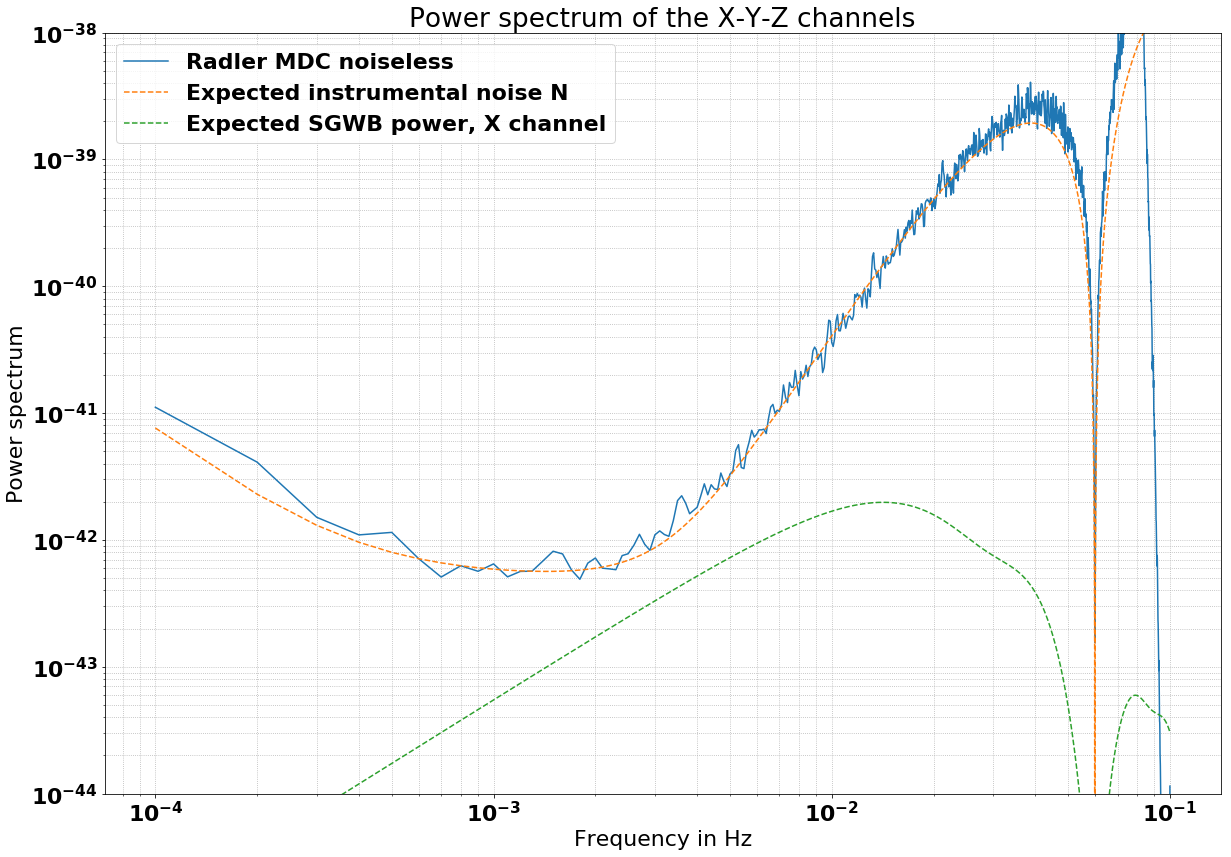

In [495]:
plt.loglog(fx, Sx, label='Radler MDC noiseless')
#plt.loglog(fx, Sx_instr + Sx_gw, label='Expected total, X channel')
plt.loglog(fx, Sx_instr,'--' ,  label='Expected instrumental noise N')
plt.loglog(fx, Sx_gw,'--' , label='Expected SGWB power, X channel')
#plt.loglog(fx, Sy_gw,'--' , label='isgwb power, Y channel')
#plt.loglog(fx, Sz_gw,'--' , label='isgwb power, Z channel')

plt.title('Power spectrum of the X-Y-Z channels')
plt.ylim(1e-44, 1e-38)
plt.legend()
plt.ylabel('Power spectrum')
plt.grid(which='both',  linestyle=':')
plt.xlabel('Frequency in Hz')

# A Channel Calculations below

In [112]:
hA = (1.0/3.0)*(2*hX - hY - hZ)
fs = 1.0/(times[1] - times[0])
fA, SA = welch(hA,fs=fs, nperseg=int(1e4*fs) )
fA, SA = fA[1:], SA[1:]

In [109]:
FA, FE, FT = tdi_isgwb_aet_response(0.5*fA/fstar)

In [110]:
## theoretical PSD :: All of these are being converted to doppler data

SA_instr = (16.0/3.0) * ((np.sin(fA/fstar))**2) * Np*(np.cos(fA/fstar) + 2) + \
             (16.0/3.0) * ((np.sin(fA/fstar))**2) * Na*(4*np.cos(fA/fstar) + 2*np.cos(2*fA/fstar) + 6)

omega_f = 3.5e-9 * (fx/25)**0.667
H0 = 2.2*10**(-18)

SA_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fA**3) * FA * (4*np.pi*fA*Larm/cspeed)**2 
SE_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fA**3) * FE * (4*np.pi*fA*Larm/cspeed)**2 
ST_gw = omega_f * (3*H0**2)/(4 * np.pi**2 * fA**3) * FT * (4*np.pi*fA*Larm/cspeed)**2 

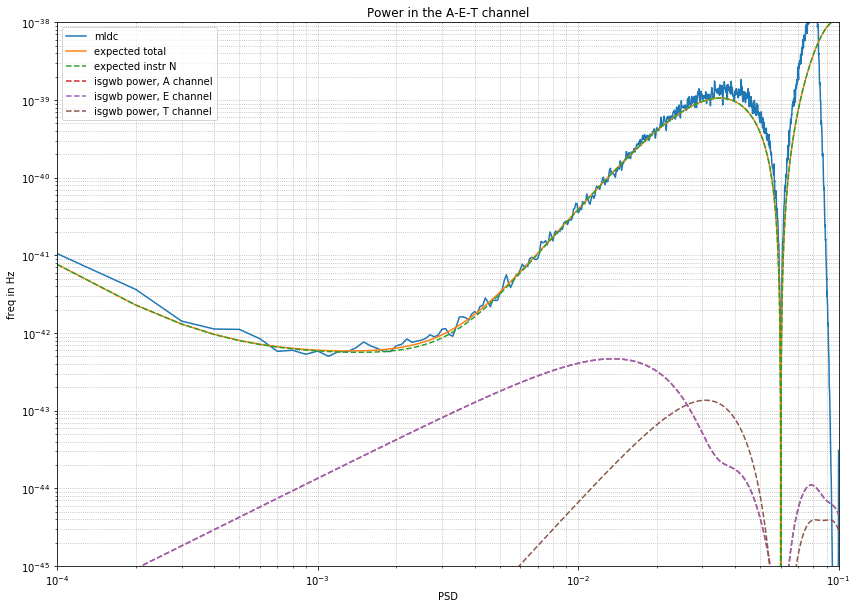

In [113]:
plt.loglog(fA, SA, label='mldc')
plt.loglog(fA, SA_instr + SA_gw, label='expected total')
plt.loglog(fA, SA_instr,'--' ,  label='expected instr N')
plt.loglog(fA, SA_gw,'--' , label='isgwb power, A channel')
plt.loglog(fA, SE_gw,'--' , label='isgwb power, E channel')
plt.loglog(fA, ST_gw,'--' , label='isgwb power, T channel')
plt.title('Power in the A-E-T channel')
plt.ylim(1e-45, 1e-38)

plt.xlim(1e-4, 1e-1)
plt.xlabel('PSD')
plt.ylabel('freq in Hz')
plt.grid( linestyle=':', which='both')
plt.legend()

# Detection response calculations

In [93]:
def tdi_isgwb_aet_response(f0): 

        '''
        Calcualte the Antenna pattern/ detector transfer function functions to an isotropic SGWB using X, Y and Z TDI channels. Note that since this is the response to an isotropic background, the response function is integrated over sky direction and averaged over polarozation. The angular integral is a linear and rectangular in the cos(theta) and phi space.  Note that f0 is (pi*L*f)/c and is input as an array

        

        Parameters
        -----------

        f0   : float
            A numpy array of scaled frequencies (see above for def)

    

        Returns
        ---------

        R1, R2 and R3   :   float
            Antenna Patterns for the given sky direction for the three channels, integrated over sky direction and averaged over polarization.
        '''

        tt = np.arange(-1, 1, 0.01)
        pp = np.arange(0, 2*np.pi, np.pi/100)

        [ct, phi] = np.meshgrid(tt,pp)
        dct = ct[0, 1] - ct[0,0]
        dphi = phi[1,0] - phi[0,0]

        ## udir is just u.r, where r is the directional vector
        udir = np.sqrt(1-ct**2) * np.sin(phi + np.pi/6)
        vdir = np.sqrt(1-ct**2) * np.sin(phi - np.pi/6)
        wdir = vdir - udir

        # Initlize arrays for the detector reponse
        R1 = np.zeros(f0.size)
        R2 = np.zeros(f0.size)
        R3 = np.zeros(f0.size)

        # Calculate the detector response for each frequency
        for ii in range(0, f0.size):

            # Calculate GW transfer function for the michelson channels
            gammaU_plus    =    1/2 * (np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(3+udir)) + \
                             np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(1+udir)))

            gammaV_plus    =    1/2 * (np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(3+vdir)) + \
                             np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(1+vdir)))

            gammaW_plus    =    1/2 * (np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(3+wdir)) + \
                             np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(1+wdir)))
            
            
            # Calculate GW transfer function for the michelson channels
            gammaU_minus    =    1/2 * (np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(3 - udir)) + \
                             np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(1 - udir)))

            gammaV_minus    =    1/2 * (np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(3 - vdir)) + \
                             np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(1 - vdir)))

            gammaW_minus    =    1/2 * (np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(3 - wdir)) + \
                             np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(1 - wdir)))
            

            ## response function u x u : eplus
            ##  Fplus_u = (u x u):eplus

            Fplus_u   = (1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 - \
                             np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2)  + \
                                 0.5*((np.cos(phi))**2 - ct**2))
        
            Fplus_v   = (1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 + \
                             np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) + \
                                 0.5*((np.cos(phi))**2 - ct**2))

            Fplus_w   = (1 - (1+ct**2)*(np.cos(phi))**2)

            
            #gammaU_plus, gammaV_plus, gammaW_plus = 1, 1, 1
            #gammaU_minus, gammaV_minus, gammaW_minus = 1, 1, 1
            
            ## Michelson Channel Antenna patterns for x pol
            ##  Fcross_u = 1/2(u x u)Gamma(udir, f):ecross
            Fcross_u  = - ct * (np.sin(2*phi + np.pi/3))
            Fcross_v  = - ct * (np.sin(2*phi - np.pi/3))
            Fcross_w   = ct*np.sin(2*phi)


            ## First Michelson antenna patterns
            ## Calculate Fplus
            Fplus1 = 0.5*(Fplus_u*gammaU_plus - Fplus_v*gammaV_plus)
            Fplus2 = 0.5*(Fplus_w*gammaW_plus - Fplus_u*gammaU_minus)
            Fplus3 = 0.5*(Fplus_v*gammaV_minus - Fplus_w*gammaW_minus)

            ## Calculate Fcross
            Fcross1 = 0.5*(Fcross_u*gammaU_plus - Fcross_v*gammaV_plus)
            Fcross2 = 0.5*(Fcross_w*gammaW_plus - Fcross_u*gammaU_minus)
            Fcross3 = 0.5*(Fcross_v*gammaV_minus - Fcross_w*gammaW_minus)

            ## Calculate antenna patterns for the A, E and T channels -  We are switiching to doppler channel.
            #FXplus = 2*np.sin(2*f0[ii])*(2*Fplus1 - Fplus2*np.exp(2*f0[ii]*udir) -Fplus3*np.exp(2*f0[ii]*vdir))*(2.0/3)
            #FYplus = 2*np.sin(2*f0[ii])*(Fplus3 - Fplus2*np.exp(2*f0[ii]*udir)) * (1/np.sqrt(3))
            #FZplus = 2*np.sin(2*f0[ii])*(Fplus3*np.exp(2*f0[ii]*vdir) + Fplus1 + Fplus2*np.exp(2*f0[ii]*udir))*(1.0/3)

            #FXcross = 2*np.sin(2*f0[ii])*(2*Fcross1 - Fcross2*np.exp(2*f0[ii]*udir) -Fcross3*np.exp(2*f0[ii]*vdir))*(2.0/3)
            #FYcross = 2*np.sin(2*f0[ii])*(Fcross3 - Fcross2*np.exp(2*f0[ii]*udir))* (1/np.sqrt(3))
            #FZcross = 2*np.sin(2*f0[ii])*(Fcross3*np.exp(2*f0[ii]*vdir) + Fcross1 + Fcross2*np.exp(2*f0[ii]*udir))*(1.0/3)

            FXplus = (1/3)*np.sin(2*f0[ii])*(2*Fplus1 - Fplus2 - Fplus3)
            FYplus = (1/np.sqrt(3))*np.sin(2*f0[ii])*(Fplus3 - Fplus2)
            FZplus = (1/3)*np.sin(2*f0[ii])*(Fplus1 + Fplus3 + Fplus2)

            FXcross = (1/3)*np.sin(2*f0[ii])*(2*Fcross1 - Fcross2 - Fcross3)
            FYcross = (1/np.sqrt(3))*np.sin(2*f0[ii])*(Fcross3 - Fcross2)
            FZcross = (1/3)*np.sin(2*f0[ii])*(Fcross1 + Fcross3 + Fcross2)
            
            
            ## Detector response for the TDI Channels, summed over polarization
            ## and integrated over sky direction
            R1[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FXplus))**2 + (np.absolute(FXcross))**2)
            R2[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FYplus))**2 + (np.absolute(FYcross))**2)
            R3[ii] = dct*dphi/(4*np.pi)*np.sum((np.absolute(FZplus))**2 + (np.absolute(FZcross))**2)



        return R1, R2, R3


In [434]:
def tdi_isgwb_xyz_response(f0): 

        '''
        Calcualte the Antenna pattern/ detector transfer function functions to an isotropic SGWB using X, Y and Z TDI channels. Note that since this is the response to an isotropic background, the response function is integrated over sky direction and averaged over polarozation. The angular integral is a linear and rectangular in the cos(theta) and phi space.  Note that f0 is (pi*L*f)/c and is input as an array

        

        Parameters
        -----------

        f0   : float
            A numpy array of scaled frequencies (see above for def)

    

        Returns
        ---------

        R1, R2 and R3   :   float
            Antenna Patterns for the given sky direction for the three channels, integrated over sky direction and averaged over polarization.
        '''

        tt = np.linspace(-1, 1, 200)
        pp = np.linspace(0, 2*np.pi, 200, endpoint=False)

        [ct, phi] = np.meshgrid(tt,pp)
        dct = ct[0, 1] - ct[0,0]
        dphi = phi[1,0] - phi[0,0]

        ## udir is just u.r, where r is the directional vector
        udir = np.sqrt(1-ct**2) * np.sin(phi + np.pi/6)
        vdir = np.sqrt(1-ct**2) * np.sin(phi - np.pi/6)
        wdir = vdir - udir

        # Initlize arrays for the detector reponse
        R1 = np.zeros(f0.size)
        R2 = np.zeros(f0.size)
        R3 = np.zeros(f0.size)

        # Calculate the detector response for each frequency
        for ii in range(0, f0.size):

            # Calculate GW transfer function for the michelson channels
            gammaU_plus    =    1/2 * (np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(3+udir)) + \
                             np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(1+udir)))

            gammaV_plus    =    1/2 * (np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(3+vdir)) + \
                             np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(1+vdir)))

            gammaW_plus    =    1/2 * (np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(3+wdir)) + \
                             np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(1+wdir)))
            
            
            # Calculate GW transfer function for the michelson channels
            gammaU_minus    =    1/2 * (np.sinc((f0[ii])*(1 + udir))*np.exp(-1j*f0[ii]*(3 - udir)) + \
                             np.sinc((f0[ii])*(1 - udir))*np.exp(-1j*f0[ii]*(1 - udir)))

            gammaV_minus    =    1/2 * (np.sinc((f0[ii])*(1 + vdir))*np.exp(-1j*f0[ii]*(3 - vdir)) + \
                             np.sinc((f0[ii])*(1 - vdir))*np.exp(-1j*f0[ii]*(1 - vdir)))

            gammaW_minus    =    1/2 * (np.sinc((f0[ii])*(1 + wdir))*np.exp(-1j*f0[ii]*(3 - wdir)) + \
                             np.sinc((f0[ii])*(1 - wdir))*np.exp(-1j*f0[ii]*(1 - wdir)))
            

            ## response function u x u : eplus
            ##  Fplus_u = (u x u):eplus

            Fplus_u   = (1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 - \
                             np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2)  + \
                                 0.5*((np.cos(phi))**2 - ct**2))
        
            Fplus_v   = (1/4*(1-ct**2) + 1/2*(ct**2)*(np.cos(phi))**2 + \
                             np.sqrt(3/16)*np.sin(2*phi)*(1+ct**2) + \
                                 0.5*((np.cos(phi))**2 - ct**2))

            Fplus_w   = (1 - (1+ct**2)*(np.cos(phi))**2)

                
            ## Michelson Channel Antenna patterns for x pol
            ##  Fcross_u = 1/2(u x u)Gamma(udir, f):ecross
            Fcross_u  = - ct * (np.sin(2*phi + np.pi/3))
            Fcross_v  = - ct * (np.sin(2*phi - np.pi/3))
            Fcross_w   = ct*np.sin(2*phi)


            ## First Michelson antenna patterns
            ## Calculate Fplus
            Fplus1 = 0.5*(Fplus_u*gammaU_plus - Fplus_v*gammaV_plus)
            Fplus2 = 0.5*(Fplus_w*gammaW_plus - Fplus_u*gammaU_minus)
            Fplus3 = 0.5*(Fplus_v*gammaV_minus - Fplus_w*gammaW_minus)

            ## Calculate Fcross
            Fcross1 = 0.5*(Fcross_u*gammaU_plus - Fcross_v*gammaV_plus)
            Fcross2 = 0.5*(Fcross_w*gammaW_plus - Fcross_u*gammaU_minus)
            Fcross3 = 0.5*(Fcross_v*gammaV_minus - Fcross_w*gammaW_minus)

            ## Calculate antenna patterns for the A, E and T channels -  We are switiching to doppler channel.
            FXplus = 2*np.sin(2*f0[ii])*Fplus1
            FYplus = 2*np.sin(2*f0[ii])*Fplus2
            FZplus = 2*np.sin(2*f0[ii])*Fplus3

            FXcross = 2*np.sin(2*f0[ii])*Fcross1
            FYcross = 2*np.sin(2*f0[ii])*Fcross2
            FZcross = 2*np.sin(2*f0[ii])*Fcross3

            ## Detector response for the TDI Channels, summed over polarization
            ## and integrated over sky direction
            R1[ii] = dct*dphi/(4*np.pi)*np.sum( (np.absolute(FXplus))**2 + (np.absolute(FXcross))**2 )
            R2[ii] = dct*dphi/(4*np.pi)*np.sum( (np.absolute(FYplus))**2 + (np.absolute(FYcross))**2 )
            R3[ii] = dct*dphi/(4*np.pi)*np.sum( (np.absolute(FZplus))**2 + (np.absolute(FZcross))**2 )



        return R1, R2, R3


In [427]:
Rx, Ry, Rz = tdi_isgwb_xyz_response(0.5*fx/fstar)

(1e-05, 2.0)

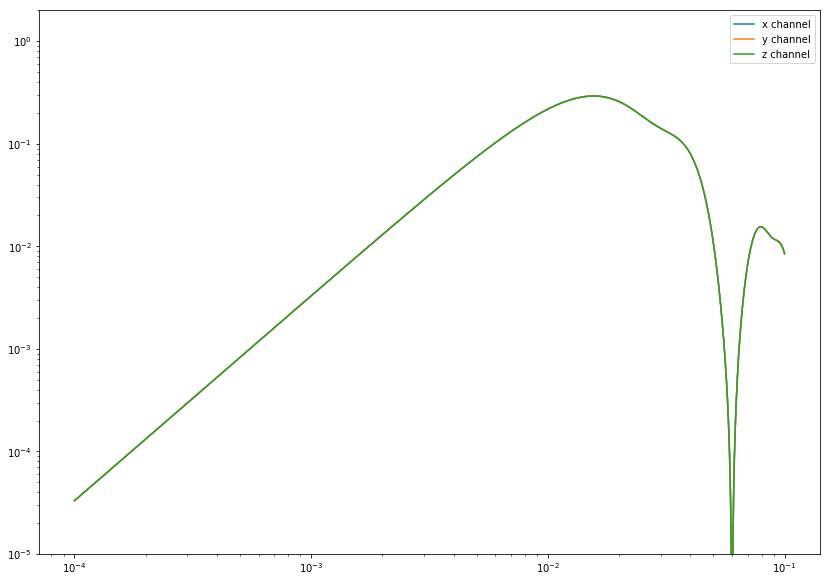

In [428]:
plt.loglog(fx, Rx, label='x channel')
plt.loglog(fx, Ry, label='y channel')
plt.loglog(fx, Rz, label='z channel')
plt.legend()
plt.ylim(1e-5, 2e0)


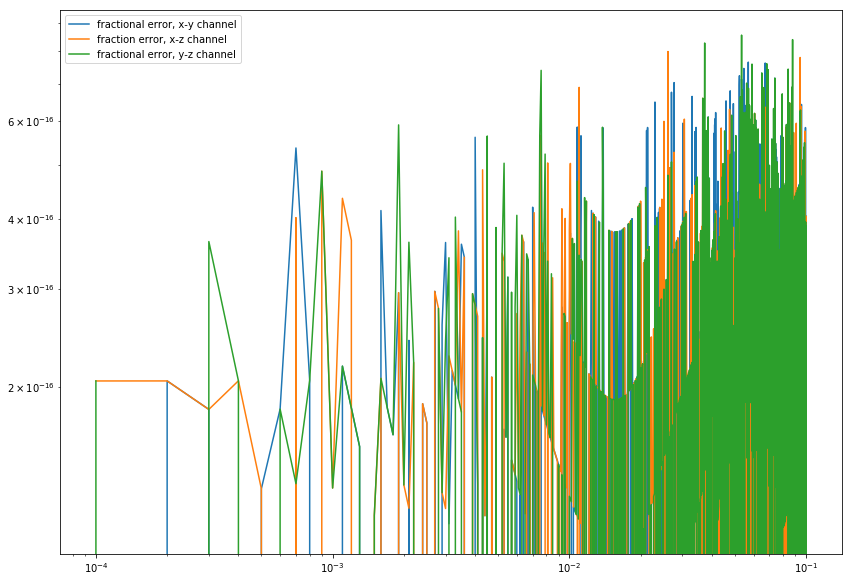

In [429]:
plt.plot(fx,np.abs((Rx-Ry)/Rx), label='fractional error, x-y channel')
plt.loglog(fx,np.abs((Rx-Rz)/Rx), label='fraction error, x-z channel')
plt.loglog(fx,np.abs((Ry-Rz)/Ry), label='fractional error, y-z channel')
plt.legend()
